In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp

import pysindy as ps

import os

import math  
import sys  
sys.path.append('C:/Users/j/hotai/myfolder')

from my_function import miscore, siscore
# Ignore matplotlib deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Seed the random number generators for reproducibility
np.random.seed(100)

integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

addp=5
startp=90
endp=120
dp=endp-startp
p_tot=addp*(dp-1)+1
file_tot=100
n=25
xstart=0
xend=25

In [2]:
def read_data(file_path,file_name,n,file_start=0,file_end=0,xstart=0,xend=0):
    x=np.zeros((121,n,n))
    y=np.zeros((121,n,n))
    vx=np.zeros((121,n,n))
    vy=np.zeros((121,n,n))
    for i in range(file_start,file_end):
        xp=[]
        yp=[]
        vxp=[]
        vyp=[]
        isvalid=[]
        xtmp=[]
        ytmp=[]
        vxtmp=[]
        vytmp=[]
        isvalidtmp=[]
        
        for root,dirs,files in os.walk(file_path):
            #print(root)
            
            for dir in dirs:
                #print(os.path.join(root,file))
                
    
                    with open(os.path.join(root,dir,file_name[i]), 'r') as f:  
                        lines = f.readlines()
                        for line in lines[3:]: 
                            num=line.split()
                            xtmp.append(float(num[0]))
                            ytmp.append(float(num[1]))
                            vxtmp.append(float(num[2]))
                            vytmp.append(float(num[3]))
                            isvalidtmp.append(float(num[4]))
        
                    xp.append(np.array(xtmp).reshape(25,25))
                    yp.append(np.array(ytmp).reshape(25,25))
                    vxp.append(np.array(vxtmp).reshape(25,25))
                    vyp.append(np.array(vytmp).reshape(25,25))
                    isvalid.append(np.array(isvalidtmp).reshape(25,25))
                    xtmp=[]
                    ytmp=[]
                    vxtmp=[]
                    vytmp=[]
                    isvalidtmp=[]
        #
        xp=np.array(xp)
        yp=np.array(yp)
        vxp=np.array(vxp)
        vyp=np.array(vyp)
        isvalid=np.array(isvalid)
        x=x+xp/file_tot
        y=y+yp/file_tot
        vx=vx+vxp/file_tot
        vy=vy+vyp/file_tot
    x=x.T
    x=x[xstart:xend,xstart:xend]
    y=y.T
    y=y[xstart:xend,xstart:xend]
    vx=vx.T
    vx=vx[xstart:xend,xstart:xend]
    vy=vy.T
    vy=vy[xstart:xend,xstart:xend]
    isvalid=isvalid.T
    isvalid=isvalid[xstart:xend,xstart:xend]
    return x,y,vx,vy

In [3]:
import random
import pandas as pd
# 计算两个点之间的欧式距离，参数为两个元组
def dist(t1, t2):
    dis = math.sqrt((np.power((t1[0]-t2[0]),2) + np.power((t1[1]-t2[1]),2)))
    # print("两点之间的距离为："+str(dis))
    return dis
 

# DBSCAN算法，参数为数据集，Eps为指定半径参数，MinPts为制定邻域密度阈值
def dbscan(Data, Eps, MinPts):
    num = len(Data)  # 点的个数
    # print("点的个数："+str(num))
    unvisited = [i for i in range(num)]  # 没有访问到的点的列表
    # print(unvisited)
    visited = []  # 已经访问的点的列表
    C = [-1 for i in range(num)]
    # C为输出结果，默认是一个长度为num的值全为-1的列表
    # 用k来标记不同的簇，k = -1表示噪声点
    k = -1
    # 如果还有没访问的点
    while len(unvisited) > 0:
        # 随机选择一个unvisited对象
        p = random.choice(unvisited)
        unvisited.remove(p)
        visited.append(p)
        # N为p的epsilon邻域中的对象的集合
        N = []
        for i in range(num):
            if (dist(Data[i], Data[p]) <= Eps):# and (i!=p):
                N.append(i)
        # 如果p的epsilon邻域中的对象数大于指定阈值，说明p是一个核心对象
        if len(N) >= MinPts:
            k = k+1
            # print(k)
            C[p] = k
            # 对于p的epsilon邻域中的每个对象pi
            for pi in N:
                if pi in unvisited:
                    unvisited.remove(pi)
                    visited.append(pi)
                    # 找到pi的邻域中的核心对象，将这些对象放入N中
                    # M是位于pi的邻域中的点的列表
                    M = []
                    for j in range(num):
                        if (dist(Data[j], Data[pi])<=Eps): #and (j!=pi):
                            M.append(j)
                    if len(M)>=MinPts:
                        for t in M:
                            if t not in N:
                                N.append(t)
                # 若pi不属于任何簇，C[pi] == -1说明C中第pi个值没有改动
                if C[pi] == -1:
                    C[pi] = k
        # 如果p的epsilon邻域中的对象数小于指定阈值，说明p是一个噪声点
        else:
            C[p] = -1
 
    return C

In [4]:

def calculate_SI_index(v, vi):
    return np.dot(v, vi) / (np.linalg.norm(v) * np.linalg.norm(vi))

def calculate_average_SI_index(vx, vy, i, j):

    si_indices = []
    v = np.array([vx[i][j], vy[i][j]])
    vi = np.array([[vx[i-1][j-1], vy[i-1][j-1]],
                   [vx[i-1][j], vy[i-1][j]],
                   [vx[i-1][j+1], vy[i-1][j+1]],
                   [vx[i][j-1], vy[i][j-1]],
                   [vx[i][j+1], vy[i][j+1]],
                   [vx[i+1][j-1], vy[i+1][j-1]],
                   [vx[i+1][j], vy[i+1][j]],
                   [vx[i+1][j+1], vy[i+1][j+1]]])
    for k in range(8):
        if np.linalg.norm(vi[k]) == 0 or np.linalg.norm(v)==0:
            continue;
        res = calculate_SI_index(v, vi[k])-np.linalg.norm(vi[k])/10;
        
        si_indices.append(res)
        
    if si_indices == []:
        si_indices.append(1)
    return np.average(si_indices)

In [5]:
def find_closest_point(vorticity_map, center_x, center_y, radius):
    # Create a mask for the circle
    y,x = np.ogrid[-center_x:vorticity_map.shape[0]-center_x, -center_y:vorticity_map.shape[1]-center_y]
    mask = x*x + y*y <= radius*radius

    masked_vorticity_map = np.ma.masked_array(vorticity_map, ~mask)
    
    closest_point = np.unravel_index(masked_vorticity_map.argmin(), masked_vorticity_map.shape)

    return closest_point[1],closest_point[0];


In [6]:
def binary_matrix_index(matrix,vx,vy):
    rows, cols = np.where(matrix == 1)
    return np.column_stack((rows, cols))


def batch_vortex_identification (vx,vy,x,y):


    # Create a meshgrid using numpy.
    #x, y = np.meshgrid(np.arange(0, 50), np.arange(0, 10))

    # print(vx.values)

    # print(np.gradient(vy.values))
    # Calculate the vorticity using numpy.


    # Identify the vortex core using the delta criterion.
    delta = vx**2 + vy**2
    # P = np.gradient(vy.values)[1]
    # Q = np.gradient(vx.values)[2]
    P = np.gradient(vx)[1] + np.gradient(vy)[0]
    Q = np.gradient(vx)[0]*np.gradient(vy)[1] - np.gradient(vx)[1]*np.gradient(vy)[0]

    delta = P**2 - 4*Q

    vortex_core = delta <-1
    '''
    vortex_core[0,:]=0
    vortex_core[-1,:]=0
    vortex_core[:,0]=0
    vortex_core[:,-1]=0
    print(vortex_core)
    '''
    #-----------------------------------------------------------------------------

    # print(vortex_core)

    vorticity = (np.gradient(vy)[1] - np.gradient(vx)[0])


    # dis = dist((1,1),(3,4))
    # print(dis)


    core_ind = binary_matrix_index(vortex_core, vx, vy)
    C = dbscan(core_ind, 4, 13)
    # print(C)
    xcls = []
    ycls = []
    for data in core_ind:
        xcls.append(data[0])
        ycls.append(data[1])
    plt.figure(figsize=(8, 6), dpi=80)
    plt.scatter(ycls,xcls, c=C, marker='^')
    plt.show()

    clusters = []
    for i in range(max(C)+1):
        cluster = []
        for j in range(len(C)):
            if C[j] == i:
                cluster.append([xcls[j], ycls[j]])
        if len(cluster) > 0:
            clusters.append(np.array(cluster))


    # Calculate the circulation and circle for each cluster of vortex core.
    # plt.figure(figsize=(5, 15))
    fig, ax = plt.subplots(figsize=(5, 5))
    result = pd.DataFrame({'center_x': [], 'center_y': [],'adj_center_x': [], 'adj_center_y': [], 'radius':[], 'strength':[], 'shape':[]})


    for cluster in clusters:
        if len(cluster) > 10:
            # cluster_vorticity = vorticity[min(cluster[0]):max(cluster[0])+1, min(cluster[1]):max(cluster[1])+1]
            cluster_vorticity = vorticity[(cluster)]
            circulation = np.sum(cluster_vorticity)
            center_y, center_x = np.mean(cluster, axis=0)
            radius = np.sqrt(np.sum((cluster - [center_y, center_x])**2)) / np.sqrt(len(cluster))
            # print(abs(1 - (len(cluster) / (np.pi * radius ** 2))))
            # print(radius)
            similarity_measurement = 'circle' if abs(1 - (len(cluster) / (np.pi * radius ** 2))) < 0.4 else 'not circle'
            

            draw_circle = plt.Circle((center_x, center_y), radius, color='b', fill=False, linestyle='--')
            # plt.text(center_x+radius*1.2, center_y-5, label,color='purple')
            plt.scatter(center_x,center_y,c='none', marker = 'v', edgecolors = 'blue')
            mat = np.ones((45,10))
            for i in range(1,44):
                for j in range(1,7):
                    mat[i][j] = calculate_average_SI_index(vx, vy, i, j)
            adj_center_x, adj_center_y = find_closest_point(mat, center_y, center_x, radius)
            plt.scatter(adj_center_x,adj_center_y,c='none', marker = 'v', edgecolors = 'red')
            draw_adj_circle = plt.Circle((adj_center_x, adj_center_y), radius, color='r', fill=False, linestyle='--')
            ax.add_artist(draw_circle)
            ax.add_artist(draw_adj_circle)
            label = f'Ensembled Center: ({center_x:.2f}, {center_y:.2f}), \n Adjusted Center: ({adj_center_x:.2f}, {adj_center_y:.2f}), \n Radius: {radius:.2f}, \n Strength: {circulation:.2f}, \n Shape: {similarity_measurement}'
            plt.text(center_x+radius*1.2, center_y-5, label,color='purple')
            # Add a new row to the DataFrame
            new_row = {'center_x': center_x, 'center_y': center_y,'adj_center_x': adj_center_x, 'adj_center_y': adj_center_y, 'radius':radius, 'strength':circulation, 'shape':similarity_measurement}
            result = result.append(new_row, ignore_index=True)
    # Visualize the flow field with the vortex core labeled in triangles.

    plt.quiver( vx, vy)
    # for cluster in clusters:
    #     if len(cluster) > 10:
    #         plt.triplot(cluster[:, 1], cluster[:, 0], color='r')
    plt.scatter(ycls,xcls, c=C, marker='^')

    #plt.axis([-1,10,0,50])
    #plt.xlim(-2,10)
    plt.show()
'''
    fig_save_path =  './vortex_identification/'+str(wc)+'/'
    fig_save_name = fig_save_path +str(cycle)+'-'+str(time)+'.png';
    
    res_save_name = fig_save_path +str(cycle)+'-'+str(time)+'.csv';
    
    if not os.path.exists(fig_save_path):
        os.mkdir(fig_save_path)
    # print(calculate_SI_index(vx.values,vy.values))

    result.to_csv(res_save_name)
    plt.savefig(fig_save_name,dpi=300)
    # print(cluster)
'''
    # plt.figure(figsize=(5, 15))
    # plt.contourf(mat)
    
    
    
    
#     vorticity = np.gradient(vy, axis=0) - np.gradient(vx, axis=1)
#     find_closest_point(vorticity, center_y, center_x, radius)

#     # Plot the vorticity map
#     plt.figure(figsize=(5, 15))
#     plt.contourf( vorticity)
#     plt.colorbar()
#     plt.show()

"\n    fig_save_path =  './vortex_identification/'+str(wc)+'/'\n    fig_save_name = fig_save_path +str(cycle)+'-'+str(time)+'.png';\n    \n    res_save_name = fig_save_path +str(cycle)+'-'+str(time)+'.csv';\n    \n    if not os.path.exists(fig_save_path):\n        os.mkdir(fig_save_path)\n    # print(calculate_SI_index(vx.values,vy.values))\n\n    result.to_csv(res_save_name)\n    plt.savefig(fig_save_name,dpi=300)\n    # print(cluster)\n"

In [7]:
file_path = os.path.join('D:\\', 'hotaidata','sr_C6_01')
file_name=['B00001.dat','B00002.dat','B00003.dat','B00004.dat','B00005.dat','B00006.dat','B00007.dat','B00008.dat',
           'B00009.dat','B00010.dat','B00011.dat','B00012.dat','B00013.dat','B00014.dat','B00015.dat','B00016.dat','B00017.dat',
           'B00018.dat','B00019.dat','B00020.dat','B00021.dat','B00022.dat','B00023.dat','B00024.dat','B00025.dat','B00026.dat',
           'B00027.dat','B00028.dat','B00029.dat','B00030.dat','B00031.dat','B00032.dat','B00033.dat','B00034.dat','B00035.dat',
           'B00036.dat','B00037.dat','B00038.dat','B00039.dat','B00040.dat','B00041.dat','B00042.dat','B00043.dat','B00044.dat',
           'B00045.dat','B00046.dat','B00047.dat','B00048.dat','B00049.dat','B00050.dat','B00051.dat','B00052.dat','B00053.dat',
           'B00054.dat','B00055.dat','B00056.dat','B00057.dat','B00058.dat','B00059.dat','B00060.dat','B00061.dat','B00062.dat',
           'B00063.dat','B00064.dat','B00065.dat','B00066.dat','B00067.dat','B00068.dat','B00069.dat','B00070.dat','B00071.dat',
           'B00072.dat','B00073.dat','B00074.dat','B00075.dat','B00076.dat','B00077.dat','B00078.dat','B00079.dat','B00080.dat',
           'B00081.dat','B00082.dat','B00083.dat','B00084.dat','B00085.dat','B00086.dat','B00087.dat','B00088.dat','B00089.dat',
           'B00090.dat','B00091.dat','B00092.dat','B00093.dat','B00094.dat','B00095.dat','B00096.dat','B00097.dat','B00098.dat',
           'B00099.dat','B00100.dat']
x=np.zeros((121,n,n))
y=np.zeros((121,n,n))
vx=np.zeros((121,n,n))
vy=np.zeros((121,n,n))

x,y,vx,vy=read_data(file_path,file_name,25,0,50,xstart,xend)
#print(x[0,:,:])
t=np.linspace(0,60/800,121)
dt=t[1]-t[0]

t=t[startp:endp]
print(len(t))
t_train=np.linspace(t[0],t[-1],addp*(len(t)-1)+1)
dt_train=t_train[1]-t_train[0]
print(len(t_train.shape))

30
1


In [8]:
#u is not pre adding, v add a median
spatial_grid = np.asarray([x[:,:,0].T,y[:,:,0].T]).T

n=xend-xstart

t_in=np.zeros((n,n,dp))
for i in range (dp):
    t_in[:,:,i]=t[i]

print(t_in[0,0])

u=np.zeros((n,n,121, 3))

u[:, :, :, 0] = vx
u[:, :, :, 1] = vy
u[:, :, startp:endp, 2] = t_in
u_train=np.zeros((n,n,len(t), 3))
u_train=u[:,:,startp:endp,:]

v_train=np.zeros((n,n,len(t_train),3))

for i in range(len(t)-1):
    for j in range(addp):
        v_train[:,:,addp*i+j]=(u_train[:,:,i]*(addp-j)+u_train[:,:,i+1]*j)/addp
v_train[:,:,-1]=u_train[:,:,-1]


[0.05625  0.056875 0.0575   0.058125 0.05875  0.059375 0.06     0.060625
 0.06125  0.061875 0.0625   0.063125 0.06375  0.064375 0.065    0.065625
 0.06625  0.066875 0.0675   0.068125 0.06875  0.069375 0.07     0.070625
 0.07125  0.071875 0.0725   0.073125 0.07375  0.074375]


In [9]:
op=np.zeros(len(t))
op=u_train[10,10,:,0]
op_train=np.zeros(len(t_train))
for i in range(len(t)-1):
    for j in range(addp):
        op_train[i*addp+j]=(op[i]*(addp-j)+op[i+1]*j)/addp
op_train[-1]=op[-1]
'''
plt.figure(figsize=(16, 4))
plt.plot(t,op)
plt.plot(t_train,op_train,'r--')
plt.show
'''

"\nplt.figure(figsize=(16, 4))\nplt.plot(t,op)\nplt.plot(t_train,op_train,'r--')\nplt.show\n"

In [10]:
v_train_dot = ps.FiniteDifference(axis=2)._differentiate(v_train, dt_train)

vtmp=np.zeros(v_train_dot.shape)
vtmp[:,:,0]=v_train[:,:,0]
for i in range(len(t_train)-1):
    vtmp[:,:,i+1]=vtmp[:,:,i]+v_train_dot[:,:,i]*dt_train
miscore(vtmp,v_train)
siscore(vtmp,v_train)
vtmp=v_train+v_train_dot*dt_train

vtmp[:,:,1:]=vtmp[:,:,:len(t_train)-1]
miscore(vtmp,v_train)
siscore(vtmp,v_train)


MI(average/percent):
0.9957774001416696 0.9997569597878921
SI(average/percent):
0.9999999999999895 1.0
MI(average/percent):
0.9991837746583707 0.9999779054352629
SI(average/percent):
0.9999497164065217 1.0


(0.9999497164065217, 1.0)

In [11]:
# Define PDE library that is quadratic in u, and
# fourth-order in spatial derivatives of u.    periodic=True

library_functions = [
    lambda y: y,
    lambda x: x*x,
    
    lambda x, y: x * y,
    lambda x, y: x * x * y,
    lambda x , y , z: x * y * z
]
library_function_names = [
    lambda y: y,
    lambda x: x+x,
    
    lambda x, y: x + y,
    lambda x, y: x + x + y,
    lambda x , y , z: x + y + z
]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=1,
    spatial_grid=spatial_grid,
    include_bias=True,
    is_uniform=True
    
)




print('SINDy')
model = ps.SINDy(feature_library=pde_lib, feature_names=['Vx','Vy','t'])

model.fit(v_train, x_dot=v_train_dot)
model.print()
#u_dot_stlsq = model.predict(v_train)x_dot=v_train_dot
'''
print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=50, alpha=1e-5, 
                     normalize_columns=True, max_iter=200)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer,feature_names=['Vx','Vy','t'])
model.fit(v_train, dt_train)
model.print()'''

SINDy
(Vx)' = 4662.203 1 + 46.266 Vx + 85.934 Vy + -149241.492 t + -84.658 VxVx + -62.902 VyVy + 1194413.705 tt + 7.005 VxVy + -639.295 Vxt + -1029.204 Vyt + -0.111 VxVxVy + 1313.270 VxVxt + 1077.364 VyVyt + -201.285 VxVyt + 6815.586 Vx_2 + -7919.835 Vy_2 + 588.178 Vx_1 + -3322.704 Vy_1 + -392.117 VxVx_2 + 812.069 VxVy_2 + -217146.445 Vxt_2 + -16.971 VyVx_2 + -85.560 VyVy_2 + 1733606.180 Vyt_2 + 61.362 tVx_2 + 5579.844 tVy_2 + -13728.618 tt_2 + 1.807 VxVxVx_2 + 109.076 VxVxVy_2 + 1228.644 VxVxt_2 + -815.592 VyVyVx_2 + -1042.437 VyVyVy_2 + -239.139 VyVyt_2 + 254670.779 ttVx_2 + 106.399 ttVy_2 + 17.227 ttt_2 + -2032929.553 VxVyVx_2 + 125.704 VxVyVy_2 + 17020.075 VxVyt_2 + 3688.346 VxtVx_2 + -1.078 VxtVy_2 + -1691.928 Vxtt_2 + -250.965 VytVx_2 + -1718.690 VytVy_2 + -243.745 VxVx_1 + -357.531 VxVy_1 + -11594.217 Vxt_1 + 62.962 VyVx_1 + 115.032 VyVy_1 + 37725.039 Vyt_1 + 115.303 tVx_1 + 3531.730 tVy_1 + 4211.971 tt_1 + 1.824 VxVxVx_1 + -1011.814 VxVxVy_1 + -1467.776 VxVxt_1 + -1438.768 VyVy

"\nprint('STLSQ model: ')\noptimizer = ps.STLSQ(threshold=50, alpha=1e-5, \n                     normalize_columns=True, max_iter=200)\nmodel = ps.SINDy(feature_library=pde_lib, optimizer=optimizer,feature_names=['Vx','Vy','t'])\nmodel.fit(v_train, dt_train)\nmodel.print()"

In [12]:
print("Model score: %f" % model.score(u_train, t=t))
print("Model score: %f" % model.score(u_train, t=dt))
print("Model score: %f" % model.score(v_train, t=t_train))
print("Model score: %f" % model.score(v_train, t=dt_train))

Model score: -7.056792
Model score: -22.409265
Model score: 0.374103
Model score: 0.423263


In [13]:
x_test,y_test,vx_test,vy_test=read_data(file_path,file_name,25,50,100,xstart,xend)


t_test=np.linspace(t[0],t[-1],addp*(len(t)-1)+1)
dt_test=t_test[1]-t_test[0]

si_t=np.zeros(p_tot)
mi_t=np.zeros(p_tot)
si_t_per=np.zeros(p_tot)
mi_t_per=np.zeros(p_tot)

In [14]:
#u is not pre adding, v add a median


n=xend-xstart


u[:, :, :, 0] = vx_test
u[:, :, :, 1] = vy_test

u_test=np.zeros((n,n,len(t), 3))
u_test=u[:,:,startp:endp,:]

v_test=np.zeros((n,n,len(t_test),3))
for i in range(len(t)-1):
    for j in range(addp):
        v_test[:,:,addp*i+j]=(u_test[:,:,i]*(addp-j)+u_test[:,:,i+1]*j)/addp
v_test[:,:,-1]=u_test[:,:,-1]


In [15]:
x_dot_test_predicted = model.predict(v_test)
x_dot_test_predicted=x_dot_test_predicted.reshape(n,n,p_tot,3)
tlen=len(t_train)
dot_tmp=np.array(x_dot_test_predicted)
pltpredict=np.zeros((n,n,tlen,2))
#print(dot_tmp[10,10])

In [16]:
print('add 7 point, from 80 to 120, with library x^3, derivative order 2, MI:0.6748241001379309, SI:0.8570345301079201')
print('add 7 point, from 80 to 120, with library x^3, derivative order 1, MI:0.6732771082529756, SI:0.8589308511150588')
print('add 7 point, from 80 to 120, with library x^2, derivative order 2, MI:0.6707939885275049, SI:0.8459658232811543')
print('add 7 point, from 80 to 120, with library x^2, derivative order 1, MI:0.6693806511354194, SI:0.8426666431380524')
print('add 7 point, from 90 to 120, with library x^2, derivative order 1, MI:0.6709005447980256, SI:0.8424080789942714')

pltpredict[:,:,0]=v_train[:,:,0,:2]
for i in range(tlen-1):
    pltpredict[:,:,i+1]=pltpredict[:,:,i]+dot_tmp[:,:,i,:2]*dt_train
miscore(pltpredict,v_test)
siscore(pltpredict,v_test)
#print(pltpredict[10,10])
#print(v_train[10,10])

add 7 point, from 80 to 120, with library x^3, derivative order 2, MI:0.6748241001379309, SI:0.8570345301079201
add 7 point, from 80 to 120, with library x^3, derivative order 1, MI:0.6732771082529756, SI:0.8589308511150588
add 7 point, from 80 to 120, with library x^2, derivative order 2, MI:0.6707939885275049, SI:0.8459658232811543
add 7 point, from 80 to 120, with library x^2, derivative order 1, MI:0.6693806511354194, SI:0.8426666431380524
add 7 point, from 90 to 120, with library x^2, derivative order 1, MI:0.6709005447980256, SI:0.8424080789942714
MI(average/percent):
0.8891741266145933 0.8539328325231993
SI(average/percent):
0.9955268276748094 1.0


(0.9955268276748094, 1.0)

0
MI(average/percent):
0.9576396857385286 0.9838709677419355
SI(average/percent):
0.9952581640986122 1.0


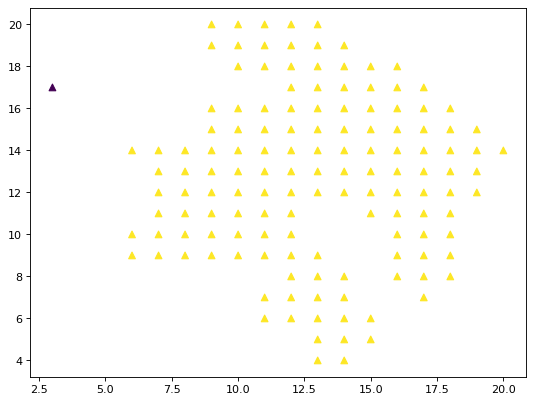

IndexError: index 25 is out of bounds for axis 0 with size 25

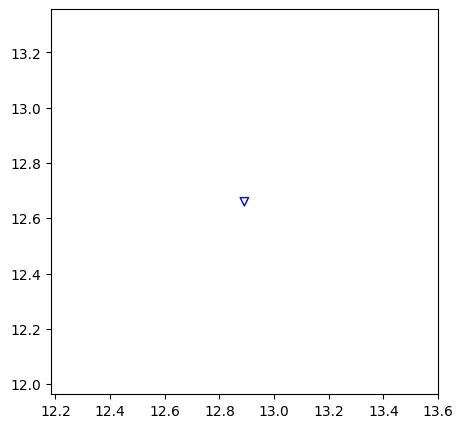

In [17]:
vxplt=np.zeros((n,n))
vyplt=np.zeros((n,n))
xplt=np.zeros((n,n))
yplt=np.zeros((n,n))
xplt=spatial_grid[:,:,0]
yplt=spatial_grid[:,:,1]
for i in range(p_tot):
    print(i)
    j=i
    mi_t[i],mi_t_per[i]=miscore(pltpredict[:,:,j,],v_test[:,:,j,:])
    si_t[i],si_t_per[i]=siscore(pltpredict[:,:,j,],v_test[:,:,j,:])
    if i%(addp)==0:
        vxplt=v_test[:,:,j,1]
        vyplt=v_test[:,:,j,0]
        batch_vortex_identification (vxplt,vyplt,xplt,yplt)
        plt.figure(figsize=(16, 4))
        plt.subplot(1, 3, 1)
        plt.title('MI percetage '+str(mi_t_per[i]))
        plt.quiver(spatial_grid[:,:,0],spatial_grid[:,:,1],v_test[:,:,j,0],v_test[:,:,j,1],color='r',label='real')
        plt.quiver(spatial_grid[:,:,0],spatial_grid[:,:,1],pltpredict[:,:,j,0],pltpredict[:,:,j,1],color='b',label='predict')
        plt.legend()
        plt.subplot(1, 3, 2)
        plt.title('SI percetage '+str(si_t_per[i]))
        plt.quiver(spatial_grid[:,:,0],spatial_grid[:,:,1],v_test[:,:,j,0],v_test[:,:,j,1],color='r',label='real')
        #plt.quiver(spatial_grid[:,:,1],spatial_grid[:,:,0],pltpredict[:,:,i,0],pltpredict[:,:,i,1],color='b')
        plt.legend()
        plt.subplot(1, 3, 3)
        #plt.quiver(spatial_grid[:,:,1],spatial_grid[:,:,0],u_dot_train[:,:,i+1,0],u_dot_train[:,:,i+1,1],color='r')
        plt.quiver(spatial_grid[:,:,0],spatial_grid[:,:,1],pltpredict[:,:,j,0],pltpredict[:,:,j,1],color='b',label='predict')
        plt.legend()
        plt.show()
    

In [ ]:
plt.figure(figsize=(12, 4))
plt.title('MI/SI~t(SINDy)')
plt.ylim(0,1)
plt.xlabel('t')
plt.ylabel('mi/si')
plt.plot(t_train,mi_t,'r',label='MI(average)')
plt.plot(t_train,si_t,'b',label='SI(average)')
plt.plot(t_train,mi_t_per,'r--',label='MI(percentage)')
plt.plot(t_train,si_t_per,'b--',label='SI(percentage)')
plt.legend()
plt.ylim(0.5, 1)
plt.plot
plt.show()